In [18]:
import pandas as pd
import json
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [19]:
# !pip install pytorch-ignite
# from ignite.contrib.metrics.regression.r2_score import R2Score

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
repository = '/content/drive/MyDrive/MyDocuments/Academic/Education after grad/UCB/IEOR 2019/Academics/Capstone/Project/Git/DemandPredictionJD/'
%cd {repository} 
%ls -a

/content/drive/MyDrive/MyDocuments/Academic/Education after grad/UCB/IEOR 2019/Academics/Capstone/Project/Git/DemandPredictionJD
 capstone_jd_msom_data-minus-click-data/
'Clustering with K-prototype .ipynb'
 .git/
 initial_data_cleaning_order.ipynb
 Inventory_optimization.ipynb
 .ipynb_checkpoints/
'OLS models - Lei.ipynb'
 order_after_engineer.csv
 order_aggregation_Lei.ipynb
 order_dict.json
 PyTorch_models_Ben.ipynb
 README.md
'Shipping - Lei.ipynb'
 sku_clustering.csv
 sku_with_cluster.csv
 warehouse_capacity_preprocessing.ipynb


In [22]:
with open('order_dict.json') as f:
    data = json.load(f)

In [23]:
order_dict = {int(k):pd.DataFrame(v).set_index('day_of_month') for k, v in data.items()}

In [24]:
order_dict[1]

,demand,day_of_week,order_hour_mode,order_hour_08,order_hour_95,att1_high,att1_miss,att2_high,att2_miss,type_1_percent,...,fast_promise,original_unit_price_mean,discount_rate_mean,direct_discount_rate_mean,quantity_discount_rate_mean,bundle_discount_mean,gift_mean,dc_ori_mode,dc_ori_num,cluster_id
day_of_month,,,,,,,,,,,,,,,,,,,,,
1,5,3,12,0.000000,1.000000,0.750000,0.250000,0.000000,0.750000,0.000000,...,0.250000,121.475000,0.070538,0.061069,0.009470,0.000000,0.000000,7,1,0
1,18,3,5,0.444444,0.555556,1.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,7,1,1
1,57,3,23,0.111111,0.400000,0.488889,0.222222,0.333333,0.355556,0.933333,...,0.888889,108.322222,0.468941,0.104816,0.238231,0.000000,0.044444,7,3,2
1,11,3,14,0.090909,0.636364,1.000000,0.000000,0.545455,0.090909,0.090909,...,0.272727,144.081818,0.669827,0.568953,0.027548,0.000000,0.000000,7,1,3
1,58,3,12,0.111111,0.416667,0.777778,0.083333,0.500000,0.111111,0.333333,...,0.472222,125.488889,0.421472,0.170375,0.178280,0.000000,0.000000,7,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,39,5,14,0.028571,0.742857,0.400000,0.342857,0.628571,0.057143,0.057143,...,0.171429,104.162857,0.335590,0.118868,0.003852,0.013378,0.028571,7,2,6
31,16,5,15,0.000000,0.866667,0.733333,0.200000,0.533333,0.200000,0.000000,...,0.000000,1.200000,0.933333,0.000000,0.000000,0.000000,0.933333,7,1,7
31,26,5,13,0.090909,0.636364,0.590909,0.272727,0.454545,0.272727,0.727273,...,0.727273,111.381818,0.412384,0.084126,NaN,0.039330,0.272727,1,3,8


In [25]:
df = order_dict[1].copy()
df = df.fillna(0)
df.replace(np.inf,0, inplace = True)

# only filter by sigfinicant features
# df = df[['demand','quantity_discount_rate_mean','cluster_id','dc_ori_mode','day_of_week']]
# df = df[['demand','quantity_discount_rate_mean']]
# df

# convert data type for categorical features
df['cluster_id'] = df['cluster_id'].astype('object')
df['dc_ori_mode'] = df['dc_ori_mode'].astype('object')
df['day_of_week'] = df['day_of_week'].astype('object')
# order_hour_mode??

cat = ['cluster_id','dc_ori_mode','day_of_week']
num = df.drop(cat+['demand'], axis = 1).columns
print(num)

Index(['order_hour_mode', 'order_hour_08', 'order_hour_95', 'att1_high',
       'att1_miss', 'att2_high', 'att2_miss', 'type_1_percent', 'no_promise',
       'fast_promise', 'original_unit_price_mean', 'discount_rate_mean',
       'direct_discount_rate_mean', 'quantity_discount_rate_mean',
       'bundle_discount_mean', 'gift_mean', 'dc_ori_num'],
      dtype='object')


In [60]:
# train test split
df_enc = pd.get_dummies(df, columns = cat, drop_first = True)
train_enc = df_enc.query('1<= day_of_month <= 24')
test_enc = df_enc.query('24 < day_of_month <= 31')

# train = df.query('1<= day_of_month <= 24')
# test = df.query('24 < day_of_month <= 31')

# train_enc = pd.get_dummies(train, columns = cat, drop_first = True)
# test_enc = pd.get_dummies(test, columns = cat)

print(train_enc.dtypes)
print(test_enc.dtypes)

# standardize data
scaler = StandardScaler()

# x_train = train_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']].to_numpy()
x_train = train_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1).to_numpy() # remove highest vif column
x_train = scaler.fit_transform(x_train)

y_train = train_enc['demand'].to_numpy().reshape(len(train_enc), 1)

# x_test = test_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']]
x_test = test_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1) 
x_test = scaler.fit_transform(x_test)

y_test = test_enc['demand'].to_numpy().reshape(len(test_enc), 1)

# print(list(zip(x_train, y_train)))
# torch.from_numpy(x_train)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

demand                           int64
order_hour_mode                  int64
order_hour_08                  float64
order_hour_95                  float64
att1_high                      float64
att1_miss                      float64
att2_high                      float64
att2_miss                      float64
type_1_percent                 float64
no_promise                     float64
fast_promise                   float64
original_unit_price_mean       float64
discount_rate_mean             float64
direct_discount_rate_mean      float64
quantity_discount_rate_mean    float64
bundle_discount_mean           float64
gift_mean                      float64
dc_ori_num                       int64
cluster_id_1                     uint8
cluster_id_2                     uint8
cluster_id_3                     uint8
cluster_id_4                     uint8
cluster_id_6                     uint8
cluster_id_7                     uint8
cluster_id_8                     uint8
cluster_id_9             

In [27]:
# # Experiment set
# x_train = np.array([[1,2,3,4,5]]).transpose()
# y_train = np.array([1,3,2,4,3]).transpose()
# print(x_train)
# print(y_train)

epoch 0, loss 454.7368469238281
epoch 200, loss 63.29451370239258
epoch 400, loss 60.17628479003906
epoch 600, loss 59.06189727783203
epoch 800, loss 58.40823745727539
epoch 1000, loss 57.97612762451172
epoch 1200, loss 57.682029724121094
epoch 1400, loss 57.47941207885742
epoch 1600, loss 57.33852005004883
epoch 1800, loss 57.23964309692383
epoch 2000, loss 57.169551849365234
epoch 2200, loss 57.11930847167969
epoch 2400, loss 57.08287811279297
epoch 2600, loss 57.05608367919922
epoch 2800, loss 57.0361328125
epoch 3000, loss 57.02104949951172
y-intercept  14.353514671325684
Coefficients  [[-0.5555501  -0.05806661 -0.01516851  0.8831459   2.4654639   0.28772703
  -1.7553455  -0.22542454  0.77203774  0.05066202  2.415731    6.8842497
  -0.92653096 -1.5982395   5.6041465   0.7205675   1.369679   -1.6062435
  -2.180742    5.0698037   5.425573    3.1901774   6.191946   -8.035353
  -0.45204294  2.9545753   0.05464951  0.8945852   0.21519913 -0.22291619
   0.3714626   2.133916    0.61102676

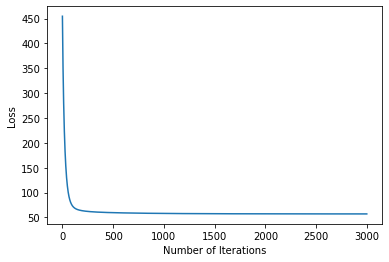

In [66]:
# define model structure
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

# From https://en.wikipedia.org/wiki/Coefficient_of_determination
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2
 
_, inputDim = x_train.shape
# inputDim = len(x_train.columns)     # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01
epochs = 3001
loss_list = []

model = linearRegression(inputDim, outputDim)
##### For GPU #######
# if torch.cuda.is_available():
#     model.cuda()

# ======================  TODO: replace MSELoss with SPO+ loss                  ========
# initialize the loss (Mean Squared Error) and optimization (Stochastic Gradient Descent)
criterion = torch.nn.MSELoss()                
# criterion = r2_loss
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learningRate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

# model training

for epoch in range(epochs):
    # Converting inputs and labels to Variable
    # if torch.cuda.is_available():
    #     inputs = Variable(torch.from_numpy(x_train).cuda())
    #     labels = Variable(torch.from_numpy(y_train).cuda())
    # else:
    #     inputs = Variable(torch.from_numpy(x_train))
    #     labels = Variable(torch.from_numpy(y_train))
    inputs = Variable(torch.from_numpy(x_train))
    labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs.type(torch.FloatTensor))

    # get loss for the predicted output
    loss = criterion(outputs, labels.type(torch.FloatTensor))
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    # store loss
    loss_list.append(loss.data)

    # print loss
    if(epoch % 200 == 0):
        print('epoch {}, loss {}'.format(epoch, loss.data))

plt.plot(range(epochs),loss_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt

# bias b (offset or y-intercept)
print('y-intercept ', model.linear.bias.item())
# weight (w)
print('Coefficients ',  model.linear.weight.detach().numpy())

Train MSE 57.02097404694504
Train R^2 Score  0.7678988909009737
Test MSE 74.97840312848116
Test R^2 Score  0.5368711824675467


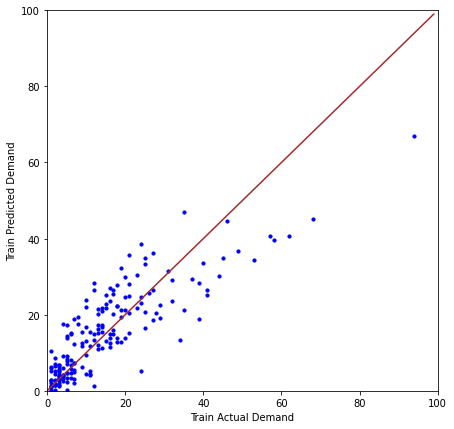

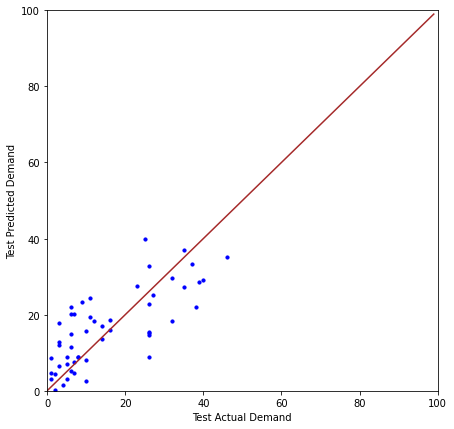

In [67]:
# Evaluation

with torch.no_grad(): # we don't need gradients in the testing phase
    # if torch.cuda.is_available():
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float().cuda())).cpu().data.numpy()
    # else:
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float())).data.numpy()
    pred_y_train = model(Variable(torch.from_numpy(x_train).float())).data.numpy()
    pred_y_test = model(Variable(torch.from_numpy(x_test).float())).data.numpy()
pred_y_train = [pred_y_train[x].item() for x in range(len(pred_y_train))]
pred_y_test = [pred_y_test[x].item() for x in range(len(pred_y_test))]

# Comparing Actual and predicted values
# print(list(zip(y_train, pred_y_train)))
# dff = {}
# dff['Actual'] = y_train
# dff['Predicted'] = pred_y_train
# dff = pd.DataFrame(dff)
# print(dff)
plt.figure(figsize=(7,7))
plt.scatter(y_train, pred_y_train, c='b', s=10)
plt.xlabel('Train Actual Demand'), plt.ylabel('Train Predicted Demand');
lim = 100
x = y = range(lim)
plt.plot(x,y, c='brown')
plt.xlim(0,lim), plt.ylim(0,lim);
plt

plt.figure(figsize=(7,7))
plt.scatter(y_test, pred_y_test, c='b', s=10)
plt.xlabel('Test Actual Demand'), plt.ylabel('Test Predicted Demand');
lim = 100
x = y = range(lim)
plt.plot(x,y, c='brown')
plt.xlim(0,lim), plt.ylim(0,lim);
plt

# metric = R2Score()
# metric.update([torch.FloatTensor(y_train), torch.FloatTensor(pred_y_train)])
# score = metric.compute()
# print('Ignite R^2 score', score)
from sklearn.metrics import mean_squared_error
print("Train MSE",mean_squared_error(y_train,pred_y_train))
print('Train R^2 Score ', r2_score(y_true=y_train, y_pred=pred_y_train)) 
print("Test MSE",mean_squared_error(y_test,pred_y_test))
print('Test R^2 Score ', r2_score(y_true=y_test, y_pred=pred_y_test)) 

In [ ]:
'''
Ref:
Lineary Regression with Pytorch
  https://medium.com/analytics-vidhya/linear-regression-with-pytorch-147fed55f138
  https://linuxhint.com/pytorch_linear_regression_tutorial/
  https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9
  https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
  https://www.reneshbedre.com/blog/pytorch-regression.html
  https://www.kaggle.com/joseguzman/multiple-regression-explained-with-pytorch?scriptVersionId=73005237
  https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#building-a-linear-regression-model-with-pytorch-gpu
Evaluations
  https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/
Quick Ordinary Lineary Regression Calculator
  https://www.socscistatistics.com/tests/regression/default.aspx

'''
